In [20]:
import pandas as pd
import sys
import os
import psycopg2
import sqlalchemy
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans



In [21]:
sys.path.append(os.path.abspath('../scripts'))

In [22]:
from load_data import *

In [23]:
query = "SELECT * FROM xdr_data"
df = load_data_from_postgres(query)

Connected to the database


/home/abrham/Documents/kifiya/week2/Telecom-Data-Analysis/scripts/load_data.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [24]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [25]:
# Group by MSISDN and aggregate session frequency, duration, and total traffic
df_grouped = df.groupby('MSISDN/Number').agg(
    session_frequency=('Bearer Id', 'count'),  # assuming bearer id is unique per session
    total_duration=('Dur. (ms)', 'sum'),
    total_traffic_dl=('Total DL (Bytes)', 'sum'),
    total_traffic_ul=('Total UL (Bytes)', 'sum')
)

df_grouped['total_traffic'] = df_grouped['total_traffic_dl'] + df_grouped['total_traffic_ul']
df_grouped = df_grouped.reset_index()

In [26]:
# Top 10 customers based on each metric
top_10_frequency = df_grouped.nlargest(10, 'session_frequency')
top_10_duration = df_grouped.nlargest(10, 'total_duration')
top_10_traffic = df_grouped.nlargest(10, 'total_traffic')

# Print the top 10 for each metric
print("Top 10 Customers by Session Frequency")
print(top_10_frequency)

print("Top 10 Customers by Session Duration")
print(top_10_duration)

print("Top 10 Customers by Total Traffic")
print(top_10_traffic)


Top 10 Customers by Session Frequency
       MSISDN/Number  session_frequency  total_duration  total_traffic_dl  \
13526   3.362632e+10                 18       8791927.0      7.301517e+09   
6437    3.361489e+10                 17       9966898.0      8.156743e+09   
13180   3.362578e+10                 17      18553754.0      7.770043e+09   
37052   3.365973e+10                 16       4035428.0      7.081602e+09   
76363   3.367588e+10                 15       4865947.0      7.309542e+09   
92923   3.376054e+10                 15       9279434.0      7.811295e+09   
65118   3.366716e+10                 13       8744914.0      5.052068e+09   
666     3.360313e+10                 12       6287761.0      4.540607e+09   
1279    3.360452e+10                 12       5207990.0      5.096079e+09   
13994   3.362708e+10                 12       4703516.0      5.309479e+09   

       total_traffic_ul  total_traffic  
13526       669650721.0   7.971167e+09  
6437        689483001.0   8.8462

In [27]:
# Top 10 customers based on each metric
top_10_frequency = df_grouped.nlargest(10, 'session_frequency')
top_10_duration = df_grouped.nlargest(10, 'total_duration')
top_10_traffic = df_grouped.nlargest(10, 'total_traffic')

# Print the top 10 for each metric
print("Top 10 Customers by Session Frequency")
print(top_10_frequency)

print("Top 10 Customers by Session Duration")
print(top_10_duration)

print("Top 10 Customers by Total Traffic")
print(top_10_traffic)


Top 10 Customers by Session Frequency
       MSISDN/Number  session_frequency  total_duration  total_traffic_dl  \
13526   3.362632e+10                 18       8791927.0      7.301517e+09   
6437    3.361489e+10                 17       9966898.0      8.156743e+09   
13180   3.362578e+10                 17      18553754.0      7.770043e+09   
37052   3.365973e+10                 16       4035428.0      7.081602e+09   
76363   3.367588e+10                 15       4865947.0      7.309542e+09   
92923   3.376054e+10                 15       9279434.0      7.811295e+09   
65118   3.366716e+10                 13       8744914.0      5.052068e+09   
666     3.360313e+10                 12       6287761.0      4.540607e+09   
1279    3.360452e+10                 12       5207990.0      5.096079e+09   
13994   3.362708e+10                 12       4703516.0      5.309479e+09   

       total_traffic_ul  total_traffic  
13526       669650721.0   7.971167e+09  
6437        689483001.0   8.8462

In [28]:
scaler = MinMaxScaler()
df_grouped[['session_frequency', 'total_duration', 'total_traffic']] = scaler.fit_transform(
    df_grouped[['session_frequency', 'total_duration', 'total_traffic']]
)

In [29]:
# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_grouped['cluster'] = kmeans.fit_predict(df_grouped[['session_frequency', 'total_duration', 'total_traffic']])
print(df_grouped['cluster'].value_counts())

cluster
2    81700
0    21159
1     3997
Name: count, dtype: int64


In [30]:
# Reverse normalization for interpretability
df_grouped[['session_frequency', 'total_duration', 'total_traffic']] = scaler.inverse_transform(
    df_grouped[['session_frequency', 'total_duration', 'total_traffic']]
)

# Compute statistics for each cluster
cluster_stats = df_grouped.groupby('cluster').agg(
    min_frequency=('session_frequency', 'min'),
    max_frequency=('session_frequency', 'max'),
    avg_frequency=('session_frequency', 'mean'),
    total_frequency=('session_frequency', 'sum'),
    
    min_duration=('total_duration', 'min'),
    max_duration=('total_duration', 'max'),
    avg_duration=('total_duration', 'mean'),
    total_duration=('total_duration', 'sum'),
    
    min_traffic=('total_traffic', 'min'),
    max_traffic=('total_traffic', 'max'),
    avg_traffic=('total_traffic', 'mean'),
    total_traffic=('total_traffic', 'sum')
)

print(cluster_stats)


         min_frequency  max_frequency  avg_frequency  total_frequency  \
cluster                                                                 
0                  1.0            4.0       2.184791          46228.0   
1                  3.0           18.0       4.258194          17020.0   
2                  0.0            2.0       1.043550          85258.0   

         min_duration  max_duration   avg_duration  total_duration  \
cluster                                                              
0             18235.0     3174824.0  215100.806229    4.551318e+09   
1             49323.0    18553754.0  572159.112084    2.286920e+09   
2              7142.0     1573420.0  107473.680857    8.780600e+09   

          min_traffic   max_traffic   avg_traffic  total_traffic  
cluster                                                           
0        2.842182e+08  1.915933e+09  1.138979e+09   2.409966e+13  
1        1.085994e+09  8.846226e+09  2.294204e+09   9.169934e+12  
2        3.3249

In [31]:
# Group by MSISDN and sum traffic per application
df_app_traffic = df.groupby('MSISDN/Number').agg(
    social_media_traffic=('Social Media DL (Bytes)', 'sum'),
    youtube_traffic=('Youtube DL (Bytes)', 'sum'),
    netflix_traffic=('Netflix DL (Bytes)', 'sum'),
    google_traffic=('Google DL (Bytes)', 'sum'),
    email_traffic=('Email DL (Bytes)', 'sum'),
    gaming_traffic=('Gaming DL (Bytes)', 'sum')
)

# Identify the top 10 users per application
top_10_social_media = df_app_traffic.nlargest(10, 'social_media_traffic')
top_10_youtube = df_app_traffic.nlargest(10, 'youtube_traffic')
top_10_netflix = df_app_traffic.nlargest(10, 'netflix_traffic')

# Print the results
print(top_10_social_media)
print(top_10_youtube)
print(top_10_netflix)


               social_media_traffic  youtube_traffic  netflix_traffic  \
MSISDN/Number                                                           
3.362632e+10             42743837.0      164048706.0      199479238.0   
3.376054e+10             39297646.0      194068298.0      146500839.0   
3.365973e+10             34900444.0      119658146.0      196277206.0   
3.361489e+10             27749744.0      199823443.0      179585986.0   
3.362578e+10             26564121.0      237883033.0      193912238.0   
3.366716e+10             23753753.0      141972692.0      167932406.0   
3.378632e+10             23568655.0      118129859.0      163602702.0   
3.366907e+10             23477047.0      136295265.0       78923699.0   
3.360313e+10             22776679.0      158976704.0      156086546.0   
3.365849e+10             22695673.0       64799443.0       78217369.0   

               google_traffic  email_traffic  gaming_traffic  
MSISDN/Number                                               

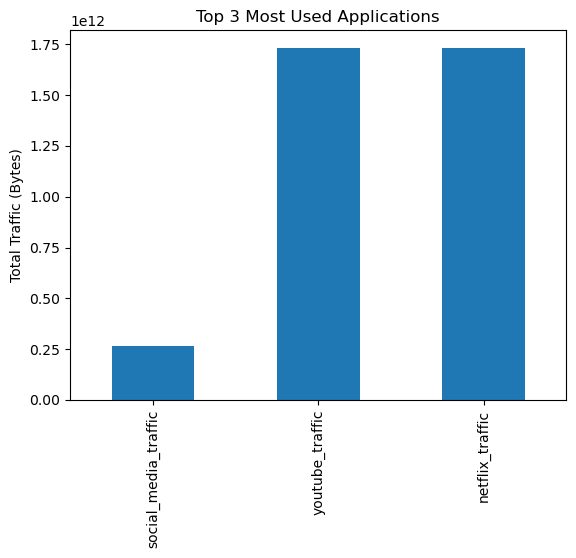

In [32]:
import matplotlib.pyplot as plt

# Plot bar chart for top 3 applications
top_apps = ['social_media_traffic', 'youtube_traffic', 'netflix_traffic']
df_app_traffic[top_apps].sum().plot(kind='bar')
plt.title('Top 3 Most Used Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.show()


In [33]:
from sklearn.metrics import silhouette_score

# Try k-means clustering for a range of k
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_grouped[['session_frequency', 'total_duration', 'total_traffic']])
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_grouped[['session_frequency', 'total_duration', 'total_traffic']], kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.plot(K, sil_scores, 'ro-', label='Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia / Silhouette Score')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()


KeyboardInterrupt: 